# Download the Dataset

Download the dataset from this link: https://www.kaggle.com/shanwizard/modest-museum-dataset

## Dataset Description

Description of the contents of the dataset can be found here: https://shan18.github.io/MODEST-Museum-Dataset

### Mount Google Drive (Works only on Google Colab)

For running the notebook on Google Colab, upload the dataset into you Google Drive and execute the two cells below

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Unzip the data from Google Drive into Colab

In [0]:
!unzip -qq '/content/gdrive/My Drive/modest_museum_dataset.zip' -d .

### Check GPU

In [0]:
!nvidia-smi

Sun May 24 19:09:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Packages

In [0]:
!pip install -r requirements.txt

# Import Packages

In [0]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import torch

from tensornet.data import MODESTMuseum
from tensornet.utils import initialize_cuda, plot_metric
from tensornet.model import DSResNetv1
from tensornet.model.optimizer import sgd
from tensornet.engine.ops import ModelCheckpoint, TensorBoard
from tensornet.engine.ops.lr_scheduler import reduce_lr_on_plateau
from loss import RmseBceDiceLoss, SsimDiceLoss, RmseBceLoss
from learner import ModelLearner

## Set Seed and Get GPU Availability

In [0]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)

GPU Available? True


## Setup Dataset

Using the MODESTMuseum class to setup dataset and create data loader

In [0]:
DATASET_PATH = 'modest_museum_dataset'

In [0]:
%%time
dataset = MODESTMuseum(
    train_batch_size=128,
    val_batch_size=128,
    cuda=cuda,
    num_workers=16,
    path='modest_museum_dataset',
    resize=(96, 96)
)

CPU times: user 6.34 s, sys: 493 ms, total: 6.83 s
Wall time: 6.84 s


## Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


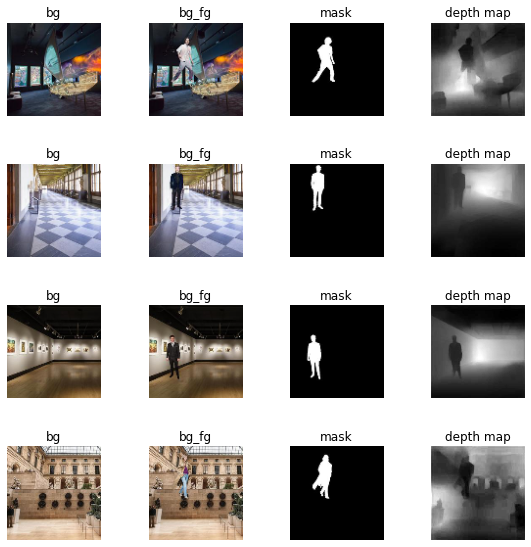

In [0]:
# Set number of data-points to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    idx = random.randint(0, len(dataset.val_data))

    # Background
    axs[i][0].axis('off')
    axs[i][0].set_title('bg')
    axs[i][0].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['bg'],
        transpose=True, data_type='bg'
    ))

    # Background-Foreground
    axs[i][1].axis('off')
    axs[i][1].set_title('bg_fg')
    axs[i][1].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['bg_fg'],
        transpose=True, data_type='bg_fg'
    ))

    # Mask
    axs[i][2].axis('off')
    axs[i][2].set_title('mask')
    axs[i][2].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['bg_fg_mask'],
        transpose=True, data_type='bg_fg_mask'
    ).squeeze(), cmap='gray')

    # Depth Map
    axs[i][3].axis('off')
    axs[i][3].set_title('depth map')
    axs[i][3].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['bg_fg_depth_map'],
        transpose=True, data_type='bg_fg_depth_map'
    ).squeeze(), cmap='gray')

## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [0]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

In [0]:
%%time
model = DSResNetv1().to(device)
model.summary({
    k: v for k, v in dataset.image_size.items() if k in ['bg', 'bg_fg']
})

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]              64
            Conv2d-2         [-1, 16, 224, 224]             448
              ReLU-3         [-1, 16, 224, 224]               0
       BatchNorm2d-4         [-1, 16, 224, 224]              32
            Conv2d-5         [-1, 16, 224, 224]           2,320
              ReLU-6         [-1, 16, 224, 224]               0
       BatchNorm2d-7         [-1, 16, 224, 224]              32
   DoubleConvBlock-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
  ResEncoderBlock-10  [[-1, 16, 112, 112], [-1, 16, 224, 224]]               0
           Conv2d-11         [-1, 32, 112, 112]             544
           Conv2d-12         [-1, 32, 112, 112]           4,640
             ReLU-13         [-1, 32, 112, 112]               0
      BatchNorm2d-14    

# Model Training and Validation

## Setup Tensorboard

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs

## Images setup
- Some images are selected at random from the validation dataset. The model will make predictions on these images after every epoch.
- This will help in gaining insights as to how is the model learning.

In [0]:
%%time
img_idxes = random.sample(range(len(dataset.val_data)), 32)

# Prepare Images
images = {
    'bg': dataset.val_data[img_idxes[0]][0]['bg'].unsqueeze(0),
    'bg_fg': dataset.val_data[img_idxes[0]][0]['bg_fg'].unsqueeze(0)
}

for idx in img_idxes[1:]:
    images['bg'] = torch.cat((
        images['bg'], dataset.val_data[idx][0]['bg'].unsqueeze(0)
    ), 0)
    images['bg_fg'] = torch.cat((
        images['bg_fg'], dataset.val_data[idx][0]['bg_fg'].unsqueeze(0)
    ), 0)

CPU times: user 457 ms, sys: 8.81 ms, total: 466 ms
Wall time: 243 ms


#### Create Directory for Saving Model Weights

In [0]:
!mkdir checkpoints

## Loss Functions

Different loss functions will be tried out to check which loss function works best with the model

### RMSE and BCE with Dice Loss

- RMSE is applied to depth output
- BCE and dice loss is applied to mask output. Loss is `BCE + 2 * Dice`
- Final loss = `2 * RMSE + (BCE + 2 * Dice)`

In [0]:
# Create model
model_1 = DSResNetv1().to(device)

In [0]:
# Create loss function
criterion = RmseBceDiceLoss()

# Create optimizer
optimizer = sgd(model_1, learning_rate=0.01, momentum=0.9)

In [0]:
# Setup Reduce LR on Plateau
scheduler = reduce_lr_on_plateau(
    optimizer, patience=2, verbose=True, min_lr=1e-6
)

# Setup Model Checkpoint
checkpoint = ModelCheckpoint(
    'checkpoints/rmse_bce_dice', monitor='val_rmse', mode='max',
    save_best_only=False, verbose=1
)

# Setup Tensorboard
tensorboard = TensorBoard('logs/rmse_bce_dice', images.copy(), device)

In [0]:
# Create Learner
epochs = 3

learner_1 = ModelLearner(
    train_loader, optimizer, criterion, device=device,
    epochs=epochs, val_loader=val_loader,
    callbacks=[scheduler, checkpoint, tensorboard],
    metrics=[['rmse'], ['iou']],
    record_train=True
)
model_1.set_learner(learner_1)

In [0]:
# Model Training
model_1.fit()

Epoch 1:
2188/2188 [========] - 838s 383ms/step - loss: 0.2490 - 0 - rmse: 0.0470 - 1 - iou: 0.7942
Validation set (took 3 minutes, 28 seconds): Average loss: 0.0015, rmse: 0.024, iou: 0.888

Saving model to checkpoints/model-epoch_1.pt

Epoch 2:
2188/2188 [========] - 837s 382ms/step - loss: 0.1812 - 0 - rmse: 0.0233 - 1 - iou: 0.8893
Validation set (took 3 minutes, 19 seconds): Average loss: 0.0014, rmse: 0.021, iou: 0.892

Saving model to checkpoints/model-epoch_2.pt

Epoch 3:
2188/2188 [========] - 835s 382ms/step - loss: 0.1742 - 0 - rmse: 0.0211 - 1 - iou: 0.8920
Validation set (took 3 minutes, 21 seconds): Average loss: 0.0014, rmse: 0.021, iou: 0.893

Saving model to checkpoints/model-epoch_3.pt



### SSIM and Dice Loss

- SSIM is applied to depth output
- Dice loss is applied to mask output.
- Final loss = `2 * SSIM + Dice`

In [0]:
# Create model
model_2 = DSResNetv1().to(device)

In [0]:
# Create loss function
criterion = SsimDiceLoss()

# Create optimizer
optimizer = sgd(model_2, learning_rate=0.01, momentum=0.9)

In [0]:
# Setup Reduce LR on Plateau
scheduler = reduce_lr_on_plateau(
    optimizer, patience=2, verbose=True, min_lr=1e-6
)

# Setup Model Checkpoint
checkpoint = ModelCheckpoint(
    'checkpoints/ssim_dice', monitor='val_rmse', mode='max',
    save_best_only=False, verbose=1
)

# Setup Tensorboard
tensorboard = TensorBoard('logs/ssim_dice', images.copy(), device)

In [0]:
# Create Learner
epochs = 3

learner_2 = ModelLearner(
    train_loader, optimizer, criterion, device=device,
    epochs=epochs, val_loader=val_loader,
    callbacks=[scheduler, checkpoint, tensorboard],
    metrics=[['rmse'], ['iou']],
    record_train=True
)
model_2.set_learner(learner_2)

In [0]:
# Model Training
model_2.fit()

Epoch 1:
1094/1094 [========] - 844s 772ms/step - loss: 0.3223 - 0 - rmse: 0.0663 - 1 - iou: 0.5936
Validation set (took 3 minutes, 48 seconds): Average loss: 0.0007, rmse: 0.024, iou: 0.877

Saving model to checkpoints/model-epoch_1.pt

Epoch 2:
1094/1094 [========] - 843s 770ms/step - loss: 0.1519 - 0 - rmse: 0.0232 - 1 - iou: 0.8812
Validation set (took 3 minutes, 30 seconds): Average loss: 0.0005, rmse: 0.021, iou: 0.888

Saving model to checkpoints/model-epoch_2.pt

Epoch 3:
1094/1094 [========] - 843s 771ms/step - loss: 0.1347 - 0 - rmse: 0.0210 - 1 - iou: 0.8889
Validation set (took 3 minutes, 39 seconds): Average loss: 0.0005, rmse: 0.02, iou: 0.891

Saving model to checkpoints/model-epoch_3.pt



### RMSE and BCE Loss

- RMSE is applied to depth output
- BCE loss is applied to mask output.
- Final loss = `2 * RMSE + BCE`

In [0]:
# Create model
model_3 = DSResNetv1().to(device)

In [0]:
# Create loss function
criterion = RmseBceLoss()

# Create optimizer
optimizer = sgd(model_3, learning_rate=0.01, momentum=0.9)

In [0]:
# Setup Reduce LR on Plateau
scheduler = reduce_lr_on_plateau(
    optimizer, patience=2, verbose=True, min_lr=1e-6
)

# Setup Model Checkpoint
checkpoint = ModelCheckpoint(
    'checkpoints/rmse_bce', monitor='val_rmse', mode='max',
    save_best_only=False, verbose=1
)

# Setup Tensorboard
tensorboard = TensorBoard('logs/rmse_bce', images.copy(), device)

In [0]:
# Create Learner
epochs = 3

learner_3 = ModelLearner(
    train_loader, optimizer, criterion, device=device,
    epochs=epochs, val_loader=val_loader,
    callbacks=[scheduler, checkpoint, tensorboard],
    metrics=[['rmse'], ['iou']],
    record_train=True
)
model_3.set_learner(learner_3)

In [0]:
# Model Training
model_3.fit()

Epoch 1:
2188/2188 [========] - 839s 383ms/step - loss: 0.0970 - 0 - rmse: 0.0458 - 1 - iou: 0.6182
Validation set (took 3 minutes, 24 seconds): Average loss: 0.0005, rmse: 0.025, iou: 0.786

Saving model to checkpoints/model-epoch_1.pt

Epoch 2:
2188/2188 [========] - 836s 382ms/step - loss: 0.0655 - 0 - rmse: 0.0236 - 1 - iou: 0.8004
Validation set (took 3 minutes, 23 seconds): Average loss: 0.0005, rmse: 0.022, iou: 0.817

Saving model to checkpoints/model-epoch_2.pt

Epoch 3:
2188/2188 [========] - 837s 383ms/step - loss: 0.0604 - 0 - rmse: 0.0216 - 1 - iou: 0.8189
Validation set (took 3 minutes, 21 seconds): Average loss: 0.0005, rmse: 0.021, iou: 0.826

Saving model to checkpoints/model-epoch_3.pt



## Comparison

### Validation Loss

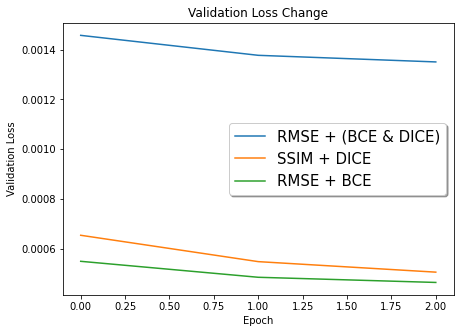

In [0]:
plot_metric({
    'RMSE + (BCE & DICE)': model_1.learner.val_losses,
    'SSIM + DICE': model_2.learner.val_losses,
    'RMSE + BCE': model_3.learner.val_losses,
}, 'Validation Loss', legend_loc='best')

### Validation IoU: Segmentation (Mask)

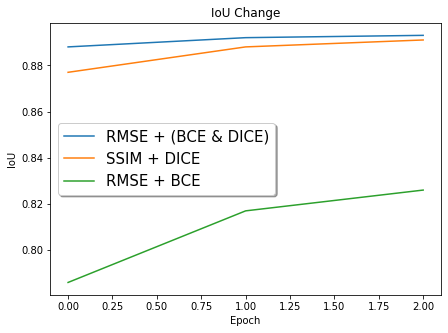

In [0]:
plot_metric({
    'RMSE + (BCE & DICE)': model_1.learner.val_metrics[1]['iou'],
    'SSIM + DICE': model_2.learner.val_metrics[1]['iou'],
    'RMSE + BCE': model_3.learner.val_metrics[1]['iou'],
}, 'IoU', legend_loc='best')

### Validation RMSE: Depth

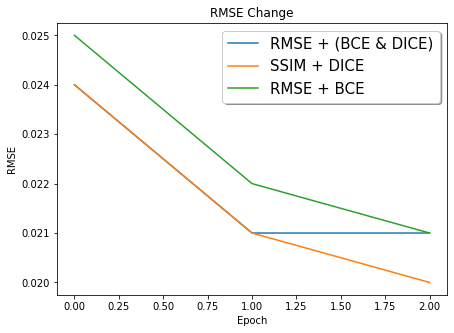

In [0]:
plot_metric({
    'RMSE + (BCE & DICE)': model_1.learner.val_metrics[0]['rmse'],
    'SSIM + DICE': model_2.learner.val_metrics[0]['rmse'],
    'RMSE + BCE': model_3.learner.val_metrics[0]['rmse'],
}, 'RMSE', legend_loc='best')